In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import data_load
import evaluation

In [2]:
import gc
gc.collect()

0

In [3]:
max_sequence_length=512

In [4]:
import torch
# always check your version
print(torch.__version__)
torch.device('mps')
# True
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('mps' if torch.backends.mps.is_available() else 'cpu')


2.1.0.dev20230818
mps


In [5]:

from gensim.models import KeyedVectors  # 用于加载GloVe词嵌入
# 加载预训练的GloVe词嵌入
glove_file = 'glove.6B/glove.6B.100d.txt'  # 替换为实际的GloVe文件路径 Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download Vocabulary Size: 400000   Embedding Dimension: 100d )
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False)
print('Loaded GloVe!')

Loaded GloVe!


In [6]:
def get_embedding_vector_for_word(word):
    if word in glove_model:
        return glove_model[word]
    else:
        return None

def review_preprocessing(X_train,X_validation,X_test):

    x_train_reviews=X_train['reviewText'].tolist()
    x_validation_reviews=X_validation['reviewText'].tolist()
    x_test_reviews=X_test['reviewText'].tolist()

    # Combine all reviews to create vocabulary
    all_reviews = x_train_reviews + x_validation_reviews + x_test_reviews

    # Build vocabulary manually
    word_index = {}
    current_index = 1  # Start index from 1
    for review in all_reviews:
        words = review.split()
        for word in words:
            if word not in word_index:
                word_index[word] = current_index
                current_index += 1
    vocab_size = len(word_index) + 1
    print('Vocabulary size:', vocab_size)

    # Initialize embedding matrix
    embedding_dim = 100  # Assuming embedding dimension is 100
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Fill embedding matrix
    for word, i in word_index.items():
        embedding_vector = get_embedding_vector_for_word(word)  # Get embedding vector for word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix shape:', embedding_matrix.shape)
    # Save embedding matrix to file
    np.save('embedding_matrix.npy', embedding_matrix)

    # Convert text to embedding representation
    def text_to_sequences(texts, word_index):
        sequences = []
        for text in texts:
            words = text.split()
            sequence = [word_index[word] for word in words if word in word_index]
            sequences.append(sequence)
        return sequences

    x_train_sequences = text_to_sequences(x_train_reviews, word_index)
    x_validation_sequences = text_to_sequences(x_validation_reviews, word_index)
    x_test_sequences = text_to_sequences(x_test_reviews, word_index)

    # Find the maximum sequence length
    # max_sequence_length = max(
    #     len(seq) for seq in x_train_sequences + x_validation_sequences + x_test_sequences
    # )
    # print('Max sequence length:', max_sequence_length)

    def pad_sequences(sequences, max_length):
        padded_sequences = []
        for seq in sequences:
            if len(seq) < max_length:
                padded_seq = seq + [0] * (max_length - len(seq))
            else:
                padded_seq = seq[:max_length]
            padded_sequences.append(padded_seq)
        return padded_sequences

    x_train_padded = pad_sequences(x_train_sequences, max_sequence_length)
    x_validation_padded = pad_sequences(x_validation_sequences, max_sequence_length)
    x_test_padded = pad_sequences(x_test_sequences, max_sequence_length)
    print('sample review:', len(x_train_padded[0]))
    print('Text preprocessing done!')
    return x_train_padded, x_validation_padded, x_test_padded


In [7]:
def features_preprocessing(X_train,X_validation,X_test):
    # do with Features
    X_train.drop(columns=['reviewText'],inplace=True)
    X_validation.drop(columns=['reviewText'],inplace=True)
    X_test.drop(columns=['reviewText'], inplace=True)


    # 定义数值特征转换器，将每个特征的值转换为均值为 0，标准差为 1 的分布，从而使得数据的分布更接近正态分布。
    scaler = StandardScaler()
    x_train_features=scaler.fit_transform(X_train)
    x_validation_features=scaler.transform(X_validation)
    x_test_features=scaler.transform(X_test)
    print('Features preprocessing done!')
    return x_train_features,x_validation_features,x_test_features

In [8]:
def create_dataloader(x_train_padded, x_validation_padded, x_test_padded, x_train_features, x_validation_features, x_test_features, y_train, y_val, y_test,batch_size):
    import torch
    # Convert the data to PyTorch tensors
    x_train_padded = torch.tensor(x_train_padded)
    x_validation_padded = torch.tensor(x_validation_padded)
    x_test_padded = torch.tensor(x_test_padded)
    x_train_features = torch.tensor(x_train_features, dtype=torch.float32)
    x_validation_features = torch.tensor(x_validation_features, dtype=torch.float32)
    x_test_features = torch.tensor(x_test_features, dtype=torch.float32)
    # y_train=y_train.values.reshape(-1,1)
    # y_val=y_val.values.reshape(-1,1)
    # y_test=y_test.values.reshape(-1,1)
    y_train = torch.tensor(y_train.tolist(), dtype=torch.float32)
    y_val = torch.tensor(y_val.tolist(), dtype=torch.float32)
    y_test = torch.tensor(y_test.tolist(), dtype=torch.float32)

    # Create TensorDatasets for train, validation, and test sets
    train_dataset = TensorDataset(x_train_padded, x_train_features, y_train)
    validation_dataset = TensorDataset(x_validation_padded, x_validation_features, y_val)
    test_dataset = TensorDataset(x_test_padded, x_test_features, y_test)

    # Create DataLoaders for train, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # for batch in train_loader:
    #     batch_inputs, batch_features, batch_labels = tuple(b.to(device) for b in batch)
    #     print(batch_inputs.shape)
    #     print(batch_features.shape)
    #     print(batch_labels.shape)
    #     break
    print('     total number of batches of train_loader:', len(train_loader) )

    return train_loader,validation_loader,test_loader


# Model

In [9]:
class GatedCNNModel(nn.Module):
    def __init__(self, embedding_matrix, num_features, num_filters, dropout):
        super(GatedCNNModel, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))

        # Gating layer
        self.gating_layer = nn.Linear(embedding_dim, 1)

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(f, embedding_dim)) for f in [2, 3, 4, 5]
        ])

        # Fully connected layers for features
        self.features_fc1 = nn.Linear(num_features * 1, 256)
        self.features_fc2 = nn.Linear(256, 128)  # Additional layer

        self.fc1 = nn.Linear(4 * num_filters + 128, 64)  # First regression layer
        self.fc2 = nn.Linear(64, 1)  # Second regression layer

        self.dropout = nn.Dropout(dropout)


    def forward(self, text, features):
        embedded = self.embedding(text)  # (batch_size, seq_len, embedding_dim)

        # Apply gating mechanism
        gate = torch.sigmoid(self.gating_layer(embedded))
        weighted_embedded = embedded * gate

        # Convolutional and max-pooling layers
        conved = [F.relu(conv(weighted_embedded.unsqueeze(1))).squeeze(3) for conv in self.convs]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat_pooled = torch.cat(pooled, dim=1)  # Concatenate pooled outputs

        # Fully connected layers for features
        features_out = self.features_fc1(features)
        features_out = self.features_fc2(features_out)

        # Concatenate CNN and features outputs
        combined = torch.cat((cat_pooled, features_out), dim=1)

        # Apply two regression layers
        regression_output = F.relu(self.fc1(self.dropout(combined)))
        output = torch.sigmoid(self.fc2(regression_output))  # Ensure [0, 1] range
        return output


In [10]:
def model_preparing( num_filter, dropout, weight_decay,lr,num_features=9 ):
    embedding_matrix=np.load('embedding_matrix.npy')

    # 实例化模型
    model = GatedCNNModel(embedding_matrix, num_features, num_filter, dropout)
    model.to(device)

    loss_function = nn.MSELoss()
    # 定义optimizer
    optimizer = torch.optim.AdamW(model.parameters(),
                      lr=lr,
                      weight_decay = weight_decay,
                      eps=1e-8)

    # 添加L2正则化（权重衰减）： 在模型的每个权重更新步骤中，通过在损失函数中添加权重的平方项，限制权重的大小。这可以防止某些权重过大，从而控制模型的复杂度。
    print('   model_preparing done!')
    return model,loss_function,optimizer

In [11]:
# 定义model evaluate function
def model_evaluate(model, loss_function, test_dataloader):
    model.eval()
    test_loss= []
    for batch in test_dataloader:
        batch_inputs, batch_features, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_features)
        loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
        test_loss.append(loss.item())
    return np.mean(test_loss)


In [12]:
#This is just to format the time that training takes
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [13]:
from matplotlib import pyplot as plt
import time
def train(num_epochs,model,train_loader,optimizer,loss_function,validation_loader,name_best,pic,stats):

    val_loss = model_evaluate(model, loss_function, validation_loader)
    best_loss = val_loss
    # best_loss=0.08622624  #eg_cnn_video_games_batch_size_32_num_filter_16_dropout_0.5_weight_decay_0.0001_lr0.001.pt
    print('     Initial validation loss:', best_loss)
    training_stats = []
    epochs_no_improve = 0
    best_epoch = 0
    t_total_start = time.time()
    for epoch in range(num_epochs):
        #starting time of training
        t_e_start = time.time()
        train_loss = 0.0
        temp=0
        model.train()
        for batch_text, batch_features, batch_labels in train_loader:
            batch_text, batch_features, batch_labels = batch_text.to(device), batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            output = model(batch_text, batch_features)
            loss = loss_function(output.squeeze(), batch_labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if temp==int((len(train_loader)-1)/2) :
                print(f'        epoch: {epoch}, batch: {temp}, avg_loss: {train_loss / (temp+1)}')
            temp=temp+1

        avg_train_loss = train_loss / len(train_loader)

        # Evaluate on validation data
        val_loss = model_evaluate(model, loss_function, validation_loader)
        training_time_epoch =format_time(time.time() - t_e_start)

        training_stats.append({
            'epoch': epoch,
            'training loss': avg_train_loss,
            'valid loss': val_loss,
            'training time': training_time_epoch
        })

        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Valid Loss: {val_loss:.4f} - Training Time: {training_time_epoch} ")


        # add early stopping
        # 训练过程中使用Early Stopping来防止过拟合。如果模型在验证集上的损失值连续3个epoch没有下降，则停止训练。
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            torch.save({'epoch': best_epoch, 'best_loss': best_loss, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, name_best)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == 3:
                print("Early Stopping! No improvement in validation loss for {} epochs.".format(epoch))
                break

    print('time elapsed for training',format_time(time.time() - t_total_start))

    print(f"the best loss for epoch {best_epoch} is {best_loss}")

    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')
    df_stats.to_csv(stats, sep='\t', index=False)
    print(df_stats)

    # Plot loss values
    plt.plot(df_stats['training loss'], label='Training Loss')
    plt.plot(df_stats['valid loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(pic)
    plt.show()

In [14]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to saved checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer used in training
    """
    # load checkpoint
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize best_loss from checkpoint to best_loss
    best_loss = checkpoint['best_loss']
    return model, optimizer, checkpoint['epoch'], best_loss

In [15]:
# Define the predict function
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch_text, batch_features, _ in test_loader:
            batch_text, batch_features = batch_text.to(device), batch_features.to(device)
            output = model(batch_text, batch_features)
            predictions.extend(output.cpu().numpy())

    predictions = np.array(predictions)
    return predictions


In [16]:
def saved_results(y_pred,y_ture,X_test,saved_path):
    X_test['y_pred'] = y_pred
    X_test['y_true'] = y_ture
    X_test.to_csv(saved_path, index=False)

In [17]:
def evaluation_cnn(y_pred,y_ture,path):
    # Reshape y_pred_video_games
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print('y_pred.shape:', y_pred.shape)

    rmse=evaluation.rmse(y_ture,y_pred)
    pcc=evaluation.pcc(y_ture,y_pred)
    ndcg=evaluation.ndcg(y_ture,y_pred)
    print('rmse:',rmse)
    print('pcc:',pcc)
    print('ndcg:',ndcg)

    # save into text file
    with open(path, 'a') as f:
        f.write('RMSE: ' + str(rmse) + '\n')
        f.write('PCC: ' + str(pcc) + '\n')
        f.write('NDCG: ' + str(ndcg) + '\n')
        f.write('\n=====================\n\n')


# Video Games

***try with video games***

In [65]:
# load data
# video_games
X_train_video_games, X_validation_video_games, X_test_video_games, y_train_video_games, y_validation_video_games, y_test_video_games = data_load.data_load(tag='all', table_name='features_video_games')

# features number :9 for all
num_features=9

/Users/xiangzhiping/Code/project_review_helpfulness/data_load.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


load features_video_games from MySQL: (18374, 11)!
features selection finished!
No null values found in the dataset.
shape of X_train: (13229, 10)
shape of X_validation: (1470, 10)
shape of X_test: (3675, 10)
shape of y_train: (13229,)
shape of y_validation: (1470,)
shape of y_test: (3675,)
Index(['reviewText', 'overall', 'review_length', 'num_sentences',
       'avg_sentence_length', 'subjectivity', 'readability', 'timeline',
       'topic', 'review_volume'],
      dtype='object')


In [66]:
#处理review
X_train_video_games_text, X_validation_video_games_text, X_test_video_games_text=review_preprocessing(X_train_video_games, X_validation_video_games, X_test_video_games)

Vocabulary size: 173529
Embedding matrix shape: (173529, 100)
sample review: 512
Text preprocessing done!


In [67]:
#处理features
X_train_video_games_features, X_validation_video_games_features, X_test_video_games_features=features_preprocessing(X_train_video_games, X_validation_video_games, X_test_video_games)

Features preprocessing done!


# ***Tune***

In [68]:
# Tune
batch_sizes=[64] #64, 128
# batch_size=32: the dataset of their paper is too small, but ours' is too large, so we need to increase the batch size for generalization
# batch_size=512:崩溃
# batch_size=256: too long,30 mins for 1 epoch

num_filters=[32] #try 32-64  ,32比16好   16,
dropouts = [0.5] # try 0.0-0.5
# dropouts= 0:过拟合在epoch==3就出现
#有论文认为dropout取值为0.5模型表现最佳（https://arxiv.org/pdf/1207.0580.pdf）
#Dropout of 50% of the hidden units significantly improves the performance of the model on all three tasks.

weight_decaies=[1e-5] # 1e-4,
#将 weigt_decay 与其他正则化方法（如 Dropout）一起使用，以提高模型的泛化性能。
#权重衰减是一种正则化项，用于控制权重的大小。初始值可以在 1e-5 到 1e-3 之间。对于大型数据集，你可以选择较小的值。权重衰减的目标是防止模型过拟合，但请注意过大的权重衰减可能导致欠拟合

learning_rates=[1e-4]
#学习率控制了参数更新的步幅。通常，你可以从较小的学习率开始，如 1e-4 或 1e-5。如果训练过程很慢或损失函数下降不稳定，你可以尝试增大学习率，例如 1e-3。使用学习率衰减策略来动态地减小学习率。
# lr=0.0005 学习率过大，validation loss震荡
#lr=0.01,batch_size=32: train loss震荡，validation loss震荡，不收敛: 原因如下：
#1. 学习率设置过大，参数更新可能会导致损失函数的震荡。参数的变化太大可能导致模型无法稳定收敛。
#2. batch_size设置过小，导致训练过程中的梯度更新过于频繁，模型无法稳定收敛。且数据中存在的异常值、噪声会特别明显，这可能会导致模型在训练时出现震荡
#3. lr=1e-5,batch_size=64: 呈下降趋势，不收敛


# 取值范围怎么来的？
#每个例子一张图
# 怎么确定？： validation loss 收敛

     total number of batches of train_loader: 207

For batch_size:  64 

 num_filter: 32
 dropout: 0.5
 weight_decay: 1e-05
 learning_rate: 0.0001
   model_preparing done!
     Initial validation loss: 0.121805634835492
        epoch: 0, batch: 103, avg_loss: 0.10541930458006951
Epoch [0/20] - Train Loss: 0.1015 - Valid Loss: 0.0963 - Training Time: 0:06:02 
        epoch: 1, batch: 103, avg_loss: 0.09692796513151664
Epoch [1/20] - Train Loss: 0.0961 - Valid Loss: 0.0941 - Training Time: 0:06:02 
        epoch: 2, batch: 103, avg_loss: 0.0950689993512172
Epoch [2/20] - Train Loss: 0.0938 - Valid Loss: 0.0926 - Training Time: 0:06:01 
        epoch: 3, batch: 103, avg_loss: 0.09304697109529605
Epoch [3/20] - Train Loss: 0.0928 - Valid Loss: 0.0906 - Training Time: 0:06:02 
        epoch: 4, batch: 103, avg_loss: 0.09294348969482459
Epoch [4/20] - Train Loss: 0.0912 - Valid Loss: 0.0905 - Training Time: 0:06:02 
        epoch: 5, batch: 103, avg_loss: 0.09025841671973467
Epoch [5/20] - T

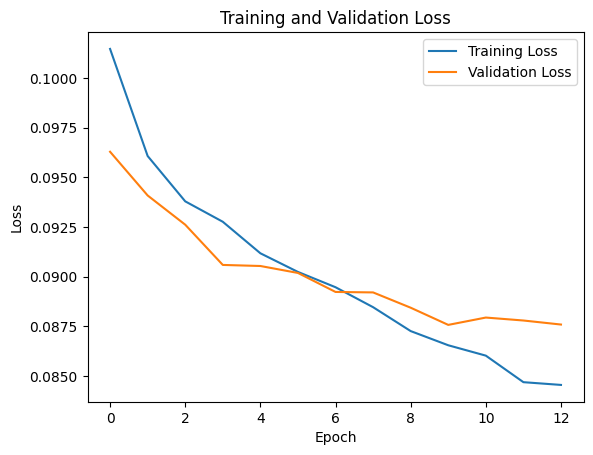

=============In this step=====================
best_loss: 0.08757294908813808
best_epoch: 9
best_batch_size: 64
best_num_filter: 32
best_dropout: 0.5
best_weight_decay: 1e-05
best_learning_rate: 0.0001
best_model_file: checkpoints/cnn_tune/eg_cnn_video_games_best_batch_size_64_num_filter_32_dropout_0.5_weight_decay_1e-05_lr_0.0001.pt


==========Results of the best one !!!!!==========
best_model_file: checkpoints/cnn_tune/eg_cnn_video_games_best_batch_size_64_num_filter_32_dropout_0.5_weight_decay_1e-05_lr_0.0001.pt
     best_loss: 0.08757294908813808
     best_epoch: 9
     best_batch_size: 64
     best_num_filter: 32
     best_dropout: 0.5
     best_weight_decay: 1e-05
     best_learning_rate: 0.0001


In [69]:
num_epochs=20
best_loss_final=10
best_loss=1
best_lr=0
best_epoch_final=0
best_batch_size=0
best_num_filter=0
best_dropout=0
best_weight_decay=0
best_model_file=''
best_model=''
for batch_size in batch_sizes:
    # create dataloader
    train_loader,validation_loader,test_loader=create_dataloader(X_train_video_games_text,X_validation_video_games_text, X_test_video_games_text, X_train_video_games_features, X_validation_video_games_features, X_test_video_games_features, y_train_video_games, y_validation_video_games, y_test_video_games,batch_size)
    print('\n============================\nFor batch_size: ',batch_size,'\n')
    for num_filter in num_filters:
        for lr in learning_rates:
            for dropout in dropouts:
                for weight_decay in weight_decaies:
                    print(' num_filter:',num_filter)
                    print(' dropout:',dropout)
                    print(' weight_decay:',weight_decay)
                    print(' learning_rate:',lr)

                    if  num_filter==32 and dropout ==0.5 and weight_decay==0.0001 and lr==0.0001:
                        print('skip this one\n')
                        continue

                   # model preparing
                    model,loss_function,optimizer=model_preparing(num_filter, dropout, weight_decay,lr,num_features)

                    # saved_file
                    name_best=f'checkpoints/cnn_tune/eg_cnn_video_games_best_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.pt'
                    pic=f'pictures/cnn_tune/eg_cnn_video_games_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.png'
                    stats=f'checkpoints/cnn_tune/eg_cnn_video_games_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.txt'

                    # train
                    train(num_epochs,model,train_loader,optimizer,loss_function,validation_loader,name_best,pic,stats)

                    # get the best model with hyperparameters
                    model, optimizer, best_epoch, best_loss= load_ckp(name_best, model, optimizer)
                    if best_loss<best_loss_final:
                        best_loss_final=best_loss
                        best_epoch_final=best_epoch
                        best_batch_size=batch_size
                        best_num_filter=num_filter
                        best_dropout=dropout
                        best_weight_decay=weight_decay
                        best_lr=lr
                        best_model_file=name_best
                        print('=============In this step=====================')
                        print('best_loss:',best_loss_final)
                        print('best_epoch:',best_epoch_final)
                        print('best_batch_size:',best_batch_size)
                        print('best_num_filter:',best_num_filter)
                        print('best_dropout:',best_dropout)
                        print('best_weight_decay:',best_weight_decay)
                        print('best_learning_rate:',best_lr)
                        print('best_model_file:',best_model_file)
                        print('==================================')

                    del model
                    del optimizer
                    del loss_function
    del train_loader
    del validation_loader
    del test_loader

print('\n==================================\n')
print('==========Results of the best one !!!!!==========')
print('best_model_file:',best_model_file)
print('     best_loss:',best_loss_final)

print('     best_epoch:',best_epoch_final)
print('     best_batch_size:',best_batch_size)
print('     best_num_filter:',best_num_filter)
print('     best_dropout:',best_dropout)
print('     best_weight_decay:',best_weight_decay)
print('     best_learning_rate:',best_lr)
# validation loss 图像末尾呈现波浪状：收敛


In [70]:
# 目前最好的：
# best_loss: 0.07785466862352271
# best_epoch: 19
# best_batch_size: 64
# best_num_filter: 32
# best_dropout: 0.5
# best_weight_decay: 1e-05
# best_learning_rate: 0.0001
# best_model_file: checkpoints/cnn_tune/eg_cnn_video_games_best_batch_size_64_num_filter_32_dropout_0.5_weight_decay_1e-05_lr_0.0001.pt

# if best_loss_final>=0.07785466862352271:
#     best_epoch=19
#     best_batch_size=64
#     best_num_filter=32
#     best_dropout=0.5
#     best_weight_decay=1e-05
#     best_lr=0.0001
#     best_model_file='checkpoints/cnn_tune/eg_cnn_video_games_best_batch_size_64_num_filter_32_dropout_0.5_weight_decay_1e-05_lr_0.0001.pt'
#     print('=============In this step=====================')
#     print('best_loss:',0.07785466862352271)
#     print('best_epoch:',best_epoch)
#     print('best_batch_size:',best_batch_size)
#     print('best_num_filter:',best_num_filter)
#     print('best_dropout:',best_dropout)
#     print('best_weight_decay:',best_weight_decay)
#     print('best_learning_rate:',best_lr)
#     print('best_model_file:',best_model_file)
#     print('==================================')

# ***Test***

In [71]:
#load best dataloader
train_loader,validation_loader,test_loader=create_dataloader(X_train_video_games_text,X_validation_video_games_text, X_test_video_games_text, X_train_video_games_features, X_validation_video_games_features, X_test_video_games_features, y_train_video_games, y_validation_video_games, y_test_video_games,best_batch_size)
del train_loader
del validation_loader

     total number of batches of train_loader: 207


In [72]:
#load best model
model,loss_function,optimizer=model_preparing(best_num_filter, best_dropout,best_weight_decay,best_lr,num_features)
model, optimizer, best_epoch, best_loss= load_ckp(best_model_file, model, optimizer)
print(model)

   model_preparing done!
GatedCNNModel(
  (embedding): Embedding(173529, 100)
  (gating_layer): Linear(in_features=100, out_features=1, bias=True)
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 100), stride=(1, 1))
    (3): Conv2d(1, 32, kernel_size=(5, 100), stride=(1, 1))
  )
  (features_fc1): Linear(in_features=9, out_features=256, bias=True)
  (features_fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [73]:

with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write('\n====================video_games====================\n')
    f.write('best_loss:'+str(best_loss)+'\n')
    f.write('best_epoch:'+str(best_epoch)+'\n')
    f.write('best_batch_size:'+str(best_batch_size)+'\n')
    f.write('best_num_filter:'+str(best_num_filter)+'\n')
    f.write('best_dropout:'+str(best_dropout)+'\n')
    f.write('best_weight_decay:'+str(best_weight_decay)+'\n')
    f.write('best_learning_rate:'+str(best_lr)+'\n')
    f.write('best_model_file:'+str(best_model_file)+'\n')
# predict
y_pred_video_games=predict(model,test_loader)
saved_path='results/cnn_video_games.csv'
saved_results(y_pred_video_games,y_test_video_games,X_test_video_games,saved_path)

In [74]:
print(type(y_pred_video_games))
print(type(y_test_video_games))
print(len(y_pred_video_games))
print(len(y_test_video_games))
print(y_pred_video_games.shape)
print(y_test_video_games.shape)


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
3675
3675
(3675, 1)
(3675,)


In [75]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write('=====================')
    f.write(' test evaluation:\n')
evaluation_cnn(y_pred_video_games,y_test_video_games,'results/evaluation_result_CNN.txt')

y_pred.shape: (3675,)
rmse: 0.2964767378696391
pcc: 0.49195539228312996
ndcg: 0.9658954239499855


In [76]:
del model
del optimizer
del loss_function
del test_loader
del X_train_video_games_text
del X_validation_video_games_text
del X_test_video_games_text
del X_train_video_games_features
del X_validation_video_games_features
del X_test_video_games_features
del y_train_video_games
del y_validation_video_games
del y_test_video_games
del y_pred_video_games
del saved_path
del best_model_file
del best_lr
del best_weight_decay
del best_dropout
del best_num_filter
del best_batch_size
del best_epoch
del best_loss
del best_loss_final
del num_epochs
del batch_sizes
del num_filters
del dropouts
del weight_decaies
del learning_rates


# ***Books***

In [30]:
# load data
# books
X_train_books, X_validation_books, X_test_books, y_train_books, y_validation_books, y_test_books = data_load.data_load(tag='all', table_name='features_books')
# features number :9 for all
num_features=9

/Users/xiangzhiping/Code/project_review_helpfulness/data_load.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


load features_books from MySQL: (81197, 11)!
features selection finished!
No null values found in the dataset.
shape of X_train: (58461, 10)
shape of X_validation: (6496, 10)
shape of X_test: (16240, 10)
shape of y_train: (58461,)
shape of y_validation: (6496,)
shape of y_test: (16240,)
Index(['reviewText', 'overall', 'review_length', 'num_sentences',
       'avg_sentence_length', 'subjectivity', 'readability', 'timeline',
       'topic', 'review_volume'],
      dtype='object')


In [31]:
#处理review
X_train_books_text, X_validation_books_text, X_test_books_text=review_preprocessing(X_train_books, X_validation_books, X_test_books)


Vocabulary size: 631878
Embedding matrix shape: (631878, 100)
sample review: 512
Text preprocessing done!


In [32]:
#处理features
X_train_books_features, X_validation_books_features, X_test_books_features=features_preprocessing(X_train_books, X_validation_books, X_test_books)


Features preprocessing done!


In [33]:
batch_size=64
num_filter=32
dropout=0.5
weight_decay=1e-05
lr=0.0001
num_epochs=20
# saved_file
name_best_books=f'checkpoints/cnn_tune/eg_cnn_books_best_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.pt'
pic_books=f'pictures/cnn_tune/eg_cnn_books_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.png'
stats_books=f'checkpoints/cnn_tune/eg_cnn_books_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.txt'


In [34]:
train_loader,validation_loader,test_loader=create_dataloader(X_train_books_text,X_validation_books_text, X_test_books_text, X_train_books_features, X_validation_books_features, X_test_books_features, y_train_books, y_validation_books, y_test_books,batch_size)

     total number of batches of train_loader: 914


In [35]:
# model preparing
model_books,loss_function_books,optimizer_books=model_preparing(num_filter, dropout, weight_decay,lr,num_features)

   model_preparing done!


     Initial validation loss: 0.13174396921314446
        epoch: 0, batch: 456, avg_loss: 0.07118301531320327
Epoch [0/20] - Train Loss: 0.0677 - Valid Loss: 0.0611 - Training Time: 0:26:41 
        epoch: 1, batch: 456, avg_loss: 0.06237965004204791
Epoch [1/20] - Train Loss: 0.0618 - Valid Loss: 0.0591 - Training Time: 0:26:41 
        epoch: 2, batch: 456, avg_loss: 0.06061636002762834
Epoch [2/20] - Train Loss: 0.0604 - Valid Loss: 0.0582 - Training Time: 0:26:41 
        epoch: 3, batch: 456, avg_loss: 0.05931479096640904
Epoch [3/20] - Train Loss: 0.0594 - Valid Loss: 0.0573 - Training Time: 0:26:41 
        epoch: 4, batch: 456, avg_loss: 0.058679241149052486
Epoch [4/20] - Train Loss: 0.0585 - Valid Loss: 0.0568 - Training Time: 0:26:42 
        epoch: 5, batch: 456, avg_loss: 0.05796794386690633
Epoch [5/20] - Train Loss: 0.0578 - Valid Loss: 0.0563 - Training Time: 0:26:40 
        epoch: 6, batch: 456, avg_loss: 0.05760066643259457
Epoch [6/20] - Train Loss: 0.0573 - Valid L

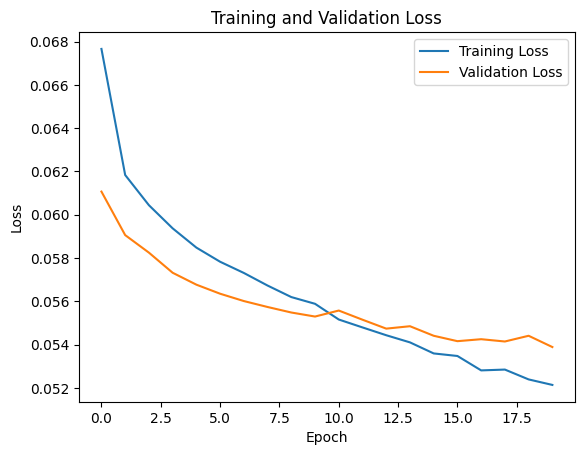

In [36]:
 # train
train(num_epochs,model_books,train_loader,optimizer_books,loss_function_books,validation_loader,name_best_books,pic_books,stats_books)

In [37]:
# load best model
model_books, optimizer_books, best_epoch_books, best_loss_books= load_ckp(name_best_books, model_books, optimizer_books)
print(model_books)

GatedCNNModel(
  (embedding): Embedding(631878, 100)
  (gating_layer): Linear(in_features=100, out_features=1, bias=True)
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 100), stride=(1, 1))
    (3): Conv2d(1, 32, kernel_size=(5, 100), stride=(1, 1))
  )
  (features_fc1): Linear(in_features=9, out_features=256, bias=True)
  (features_fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [38]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write('\n====================books====================\n')
    f.write('best_loss:'+str(best_loss_books)+'\n')
    f.write('best_epoch:'+str(best_epoch_books)+'\n')
    f.write('best_model_file:'+str(name_best_books)+'\n')

In [39]:
# predict
y_pred_books=predict(model_books,test_loader)
saved_path='results/cnn_books.csv'
saved_results(y_pred_books,y_test_books,X_test_books,saved_path)


In [40]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write(' test evaluation:\n')
evaluation_cnn(y_pred_books,y_test_books,'results/evaluation_result_CNN.txt')

y_pred.shape: (16240,)
rmse: 0.23207411236442724
pcc: 0.6181633053163821
ndcg: 0.9874771655648726


In [41]:
del model_books
del optimizer_books
del loss_function_books
del test_loader
del X_train_books_text
del X_validation_books_text
del X_test_books_text
del X_train_books_features
del X_validation_books_features
del X_test_books_features
del y_train_books
del y_validation_books
del y_test_books
del y_pred_books
del saved_path
del name_best_books
del pic_books
del stats_books
del best_epoch_books
del best_loss_books
del num_epochs
del batch_size
del num_filter
del dropout
del weight_decay
del lr
del train_loader
del validation_loader

# cell phones

In [42]:
# load data
# cell phones
X_train_cell_phones, X_validation_cell_phones, X_test_cell_phones, y_train_cell_phones, y_validation_cell_phones, y_test_cell_phones = data_load.data_load(tag='SPC', table_name='features_cell_phones')
# features number :9 for all
num_features=5

/Users/xiangzhiping/Code/project_review_helpfulness/data_load.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


load features_cell_phones from MySQL: (35667, 11)!
features selection finished!
No null values found in the dataset.
shape of X_train: (25679, 6)
shape of X_validation: (2854, 6)
shape of X_test: (7134, 6)
shape of y_train: (25679,)
shape of y_validation: (2854,)
shape of y_test: (7134,)
Index(['reviewText', 'review_volume', 'overall', 'timeline', 'review_length',
       'num_sentences'],
      dtype='object')


In [43]:
#处理review
X_train_cell_phones_text, X_validation_cell_phones_text, X_test_cell_phones_text=review_preprocessing(X_train_cell_phones, X_validation_cell_phones, X_test_cell_phones)

Vocabulary size: 156827
Embedding matrix shape: (156827, 100)
sample review: 512
Text preprocessing done!


In [44]:
#处理features
X_train_cell_phones_features, X_validation_cell_phones_features, X_test_cell_phones_features=features_preprocessing(X_train_cell_phones, X_validation_cell_phones, X_test_cell_phones)

Features preprocessing done!


In [45]:
batch_size=64
num_filter=32
dropout=0.5
weight_decay=1e-05
lr=0.0001
num_epochs=20
# saved_file
name_best_cell_phones=f'checkpoints/cnn_tune/eg_cnn_cell_phones_best_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.pt'
pic_cell_phones=f'pictures/cnn_tune/eg_cnn_cell_phones_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.png'
stats_cell_phones=f'checkpoints/cnn_tune/eg_cnn_cell_phones_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.txt'

In [46]:
train_loader,validation_loader,test_loader=create_dataloader(X_train_cell_phones_text,X_validation_cell_phones_text, X_test_cell_phones_text, X_train_cell_phones_features, X_validation_cell_phones_features, X_test_cell_phones_features, y_train_cell_phones, y_validation_cell_phones, y_test_cell_phones,batch_size)


     total number of batches of train_loader: 402


In [47]:
# model preparing
model_cell_phones,loss_function_cell_phones,optimizer_cell_phones=model_preparing(num_filter, dropout, weight_decay,lr,num_features)


   model_preparing done!


     Initial validation loss: 0.15544235325521893
        epoch: 0, batch: 200, avg_loss: 0.09258086862626361
Epoch [0/20] - Train Loss: 0.0881 - Valid Loss: 0.0845 - Training Time: 0:11:44 
        epoch: 1, batch: 200, avg_loss: 0.08344731413161577
Epoch [1/20] - Train Loss: 0.0836 - Valid Loss: 0.0839 - Training Time: 0:11:44 
        epoch: 2, batch: 200, avg_loss: 0.08328640529543013
Epoch [2/20] - Train Loss: 0.0828 - Valid Loss: 0.0827 - Training Time: 0:11:42 
        epoch: 3, batch: 200, avg_loss: 0.08338062543032775
Epoch [3/20] - Train Loss: 0.0822 - Valid Loss: 0.0821 - Training Time: 0:11:42 
        epoch: 4, batch: 200, avg_loss: 0.08169376197739027
Epoch [4/20] - Train Loss: 0.0816 - Valid Loss: 0.0819 - Training Time: 0:11:42 
        epoch: 5, batch: 200, avg_loss: 0.08187471081813176
Epoch [5/20] - Train Loss: 0.0809 - Valid Loss: 0.0816 - Training Time: 0:11:45 
        epoch: 6, batch: 200, avg_loss: 0.08041109007537661
Epoch [6/20] - Train Loss: 0.0808 - Valid Lo

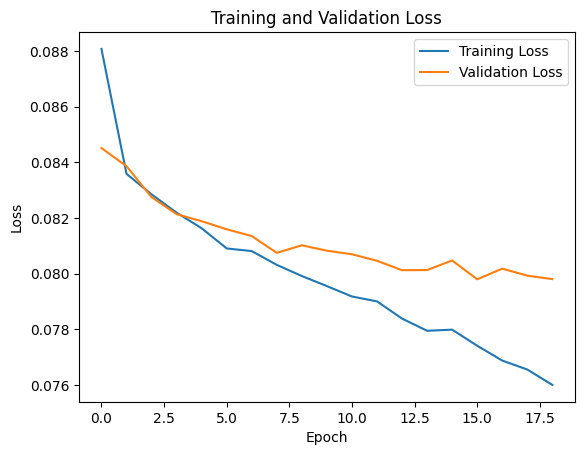

In [48]:
    # train
train(num_epochs,model_cell_phones,train_loader,optimizer_cell_phones,loss_function_cell_phones,validation_loader,name_best_cell_phones,pic_cell_phones,stats_cell_phones)


In [49]:
# load best model
model_cell_phones, optimizer_cell_phones, best_epoch_cell_phones, best_loss_cell_phones= load_ckp(name_best_cell_phones, model_cell_phones, optimizer_cell_phones)
print(model_cell_phones)

GatedCNNModel(
  (embedding): Embedding(156827, 100)
  (gating_layer): Linear(in_features=100, out_features=1, bias=True)
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 100), stride=(1, 1))
    (3): Conv2d(1, 32, kernel_size=(5, 100), stride=(1, 1))
  )
  (features_fc1): Linear(in_features=5, out_features=256, bias=True)
  (features_fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [50]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write('\n====================cell_phones====================\n')
    f.write('best_loss:'+str(best_loss_cell_phones)+'\n')
    f.write('best_epoch:'+str(best_epoch_cell_phones)+'\n')
    f.write('best_model_file:'+str(name_best_cell_phones)+'\n')

In [51]:
# predict
y_pred_cell_phones=predict(model_cell_phones,test_loader)
saved_path='results/cnn_cell_phones.csv'
saved_results(y_pred_cell_phones,y_test_cell_phones,X_test_cell_phones,saved_path)

In [52]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write(' test evaluation:\n')
evaluation_cnn(y_pred_cell_phones,y_test_cell_phones,'results/evaluation_result_CNN.txt')

y_pred.shape: (7134,)
rmse: 0.2795228197579774
pcc: 0.42536690710992753
ndcg: 0.9818138441666545


In [53]:
del model_cell_phones
del optimizer_cell_phones
del loss_function_cell_phones
del test_loader
del X_train_cell_phones_text
del X_validation_cell_phones_text
del X_test_cell_phones_text
del X_train_cell_phones_features
del X_validation_cell_phones_features
del X_test_cell_phones_features
del y_train_cell_phones
del y_validation_cell_phones
del y_test_cell_phones
del y_pred_cell_phones
del saved_path
del name_best_cell_phones

# ***electronics***

In [54]:
# load data
# electronics
X_train_electronics, X_validation_electronics, X_test_electronics, y_train_electronics, y_validation_electronics, y_test_electronics = data_load.data_load(tag='SPC', table_name='features_electronics')
num_features=5

/Users/xiangzhiping/Code/project_review_helpfulness/data_load.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


load features_electronics from MySQL: (64577, 11)!
features selection finished!
No null values found in the dataset.
shape of X_train: (46494, 6)
shape of X_validation: (5167, 6)
shape of X_test: (12916, 6)
shape of y_train: (46494,)
shape of y_validation: (5167,)
shape of y_test: (12916,)
Index(['reviewText', 'review_volume', 'overall', 'readability',
       'review_length', 'num_sentences'],
      dtype='object')


In [55]:
#处理review
X_train_electronics_text, X_validation_electronics_text, X_test_electronics_text=review_preprocessing(X_train_electronics, X_validation_electronics, X_test_electronics)

Vocabulary size: 339539
Embedding matrix shape: (339539, 100)
sample review: 512
Text preprocessing done!


In [56]:
#处理features
X_train_electronics_features, X_validation_electronics_features, X_test_electronics_features=features_preprocessing(X_train_electronics, X_validation_electronics, X_test_electronics)

Features preprocessing done!


In [57]:
batch_size=64
num_filter=32
dropout=0.5
weight_decay=1e-05
lr=0.0001
num_epochs=20
# saved_file
name_best_electronics=f'checkpoints/cnn_tune/eg_cnn_electronics_best_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.pt'
pic_electronics=f'pictures/cnn_tune/eg_cnn_electronics_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.png'
stats_electronics=f'checkpoints/cnn_tune/eg_cnn_electronics_batch_size_{batch_size}_num_filter_{num_filter}_dropout_{dropout}_weight_decay_{weight_decay}_lr_{lr}.txt'


In [58]:
train_loader,validation_loader,test_loader=create_dataloader(X_train_electronics_text,X_validation_electronics_text, X_test_electronics_text, X_train_electronics_features, X_validation_electronics_features, X_test_electronics_features, y_train_electronics, y_validation_electronics, y_test_electronics,batch_size)

     total number of batches of train_loader: 727


In [59]:
# model preparing
model_electronics,loss_function_electronics,optimizer_electronics=model_preparing(num_filter, dropout, weight_decay,lr,num_features)


   model_preparing done!


     Initial validation loss: 0.16686955591042837
        epoch: 0, batch: 363, avg_loss: 0.0931164374738768
Epoch [0/20] - Train Loss: 0.0901 - Valid Loss: 0.0852 - Training Time: 0:21:13 
        epoch: 1, batch: 363, avg_loss: 0.08630069606210831
Epoch [1/20] - Train Loss: 0.0860 - Valid Loss: 0.0837 - Training Time: 0:21:12 
        epoch: 2, batch: 363, avg_loss: 0.08499543692220698
Epoch [2/20] - Train Loss: 0.0847 - Valid Loss: 0.0825 - Training Time: 0:21:13 
        epoch: 3, batch: 363, avg_loss: 0.08394093720426599
Epoch [3/20] - Train Loss: 0.0839 - Valid Loss: 0.0821 - Training Time: 0:21:12 
        epoch: 4, batch: 363, avg_loss: 0.08383474654548771
Epoch [4/20] - Train Loss: 0.0830 - Valid Loss: 0.0817 - Training Time: 0:21:13 
        epoch: 5, batch: 363, avg_loss: 0.08319811998856264
Epoch [5/20] - Train Loss: 0.0824 - Valid Loss: 0.0815 - Training Time: 0:21:14 
        epoch: 6, batch: 363, avg_loss: 0.08165344674713336
Epoch [6/20] - Train Loss: 0.0819 - Valid Los

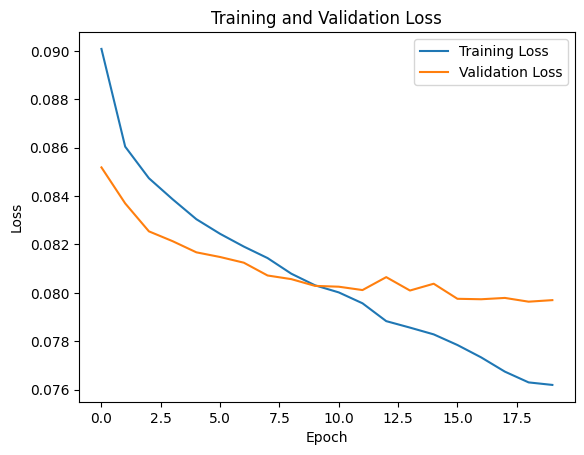

In [60]:
    # train
train(num_epochs,model_electronics,train_loader,optimizer_electronics,loss_function_electronics,validation_loader,name_best_electronics,pic_electronics,stats_electronics)

In [61]:
# load best model
model_electronics, optimizer_electronics, best_epoch_electronics, best_loss_electronics= load_ckp(name_best_electronics, model_electronics, optimizer_electronics)

In [62]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write('\n====================electronics====================\n')
    f.write('best_loss:'+str(best_loss_electronics)+'\n')
    f.write('best_epoch:'+str(best_epoch_electronics)+'\n')
    f.write('best_model_file:'+str(name_best_electronics)+'\n')

In [63]:
# predict
y_pred_electronics=predict(model_electronics,test_loader)
saved_path='results/cnn_electronics.csv'
saved_results(y_pred_electronics,y_test_electronics,X_test_electronics,saved_path)

In [64]:
with open('results/evaluation_result_CNN.txt', 'a') as f:
    f.write(' test evaluation:\n')
evaluation_cnn(y_pred_electronics,y_test_electronics,'results/evaluation_result_CNN.txt')


y_pred.shape: (12916,)
rmse: 0.2848093616082267
pcc: 0.4729156598625768
ndcg: 0.9829425750081963
